# Analyze color names from paint companies. Answer questions about distribution of terms and patterns. Train generative model.

<h1>Other Similar Projects</h1>
<p>I'm not the first by far to have attempted to learn to generate color names from examples. Here are some notable predecessors:
<ul>
<li>colorbot is where the data came from, and uses a recurrent neural net to generate new names.
<li><a href="https://github.com/waweber/colorbot">Waweber's python project on github using Tensorflow to generate color names from RGB and vice-versa.</a>
<li>Chir.ag's <a href="http://chir.ag/projects/name-that-color/#B8BF88">'Name That Color' app</a> finds the closest match to your selection - not doing language generation.



## Questions to answer:
### 1. Histogram of number of words in color names
### 2. Can we tag part-of-speech on color names, what patterns exist?
### 3. What are the frequencies of 2-word and three-word patterns?
### 4. What is the list of basic color terms?
### How many have basic color word, how many don't include a basic color word
### Make map of rgb spectrum + basic color terms


## Import libraries

In [1]:
from os import path
import sys
import csv
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
from nltk import pos_tag
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from nltk import FreqDist

## Read in raw data

In [2]:
paint_companies = ['sherwinwilliams', 'behr', 'resene', 'benjaminmoore']

dataframes = []

for paint_company in paint_companies:
    filename = path.normpath('.\\colorbot\\data\\scraped\\'+ paint_company + '\\db.csv')
    temp = pd.read_csv(filename, names= ['color_name', 'red', 'green', 'blue'])
    
    dataframes.append(temp)

    sys.stderr.write("Read {} lines from {}\n".format(len(temp), paint_company))
       
color_names = pd.concat(dataframes)


Read 1482 lines from sherwinwilliams
Read 5276 lines from behr
Read 1383 lines from resene
Read 3835 lines from benjaminmoore


In [3]:
color_names.tail(5)


,color_name,red,green,blue
3830,misty rose,234,206,215
3831,countryside pink,222,179,199
3832,sweet caroline,214,220,186
3833,apple blossom,203,211,174
3834,luscious,217,179,203


In [4]:
tok = TreebankWordTokenizer()

## Add a uid to each row

In [5]:
color_names['uid'] = 0
color_uid = 0
for index, row in color_names.iterrows():
    color_names.at[index, 'uid'] = color_uid
    color_uid += 1

In [6]:
color_names.tail(5)

,color_name,red,green,blue,uid
3830,misty rose,234,206,215,11971
3831,countryside pink,222,179,199,11972
3832,sweet caroline,214,220,186,11973
3833,apple blossom,203,211,174,11974
3834,luscious,217,179,203,11975


### Count number of words, make histogram

In [7]:
lengths = [0,0,0,0,0,0]
patterns = {}
words = []
for name in color_names.color_name:
    tokens = tok.tokenize(name)
    words += tokens
    tagged_tokens = pos_tag(tokens)
    tags = [item[1] for item in tagged_tokens]
    pattern = tuple(tags)
    length = len(tokens)
    lengths[length] += 1
    
    if (pattern in patterns.keys()):
        patterns[pattern] += 1
    else:
        patterns[pattern] = 1
     
print("Number of names with n tokens:")
print(lengths)
    

Number of names with n tokens:
[0, 2725, 8605, 599, 45, 2]


In [8]:
fd = FreqDist(words)

In [9]:
len(fd.keys())

6057

## Assumption: The most common terms are the basic color terms

In [10]:
basic_color_terms = [c for (c, f) in fd.most_common(43)]

In [11]:
# Drop some that don't make sense, like 'of', etc
drop = ['of', 'mist', 'sea', 'sweet', 'spring', 'ice', 'sky', 'light', 'garden', 'stone', 'deep', 
                          'golden', 'dark', 'pale', 'soft', 'the', 'fresh', 'mountain', 'sage', 'desert']
basic_color_terms = [color for color in basic_color_terms if color not in drop]

In [12]:
print("|".join(basic_color_terms))

blue|green|white|gray|pink|brown|red|gold|rose|tan|cream|yellow|peach|beige|orange|violet|black|silver|sand|coral|purple|teal|clay|plum|lilac|taupe|grey


<i>We've arrived at a good list of basic color terms, just starting from the paint color names. The only expert knowledge baked into this list comes from the stop words.</i>

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


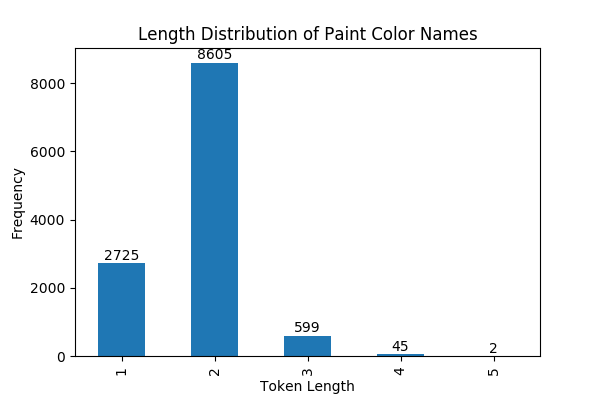

In [14]:
length_series = pd.Series.from_array(lengths)
plt.figure(figsize=(6, 4))
ax = length_series[1:6].plot(kind='bar')
ax.set_title('Length Distribution of Paint Color Names')
ax.set_xlabel('Token Length')
ax.set_ylabel('Frequency')
ax.set_xticklabels([str(num) for num in range(1,6)])
rects = ax.patches

# Make some labels.
labels = lengths[1:6]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

<i>We've got the distribution of lengths of color names - most have 2, a few have 1, fewer stil have 3 or 4. We'll try to generate new names to match this distribution.
Next we'll start analyzing the part of speech of each element of the color name.  When we generate new names, we'll want to match this aspect of the distribution too.</i>

## Count the occurrences of each POS Pattern in the corpus

In [15]:
patterns_sorted_by_value = sorted(patterns.items(), key=lambda kv: kv[1], reverse=True)
print(patterns_sorted_by_value[0:19])

[(('NN', 'NN'), 4270), (('NN',), 2449), (('JJ', 'NN'), 2233), (('VBN', 'NN'), 278), (('NN', 'NNS'), 207), (('VBG', 'NN'), 189), (('NN', 'VBD'), 165), (('JJ', 'JJ'), 141), (('RB', 'NN'), 135), (('NNS', 'NN'), 132), (('NN', 'NN', 'NN'), 127), (('JJ', 'NN', 'NN'), 126), (('NN', 'JJ'), 116), (('JJ',), 103), (('NNS', 'VBP'), 101), (('JJ', 'NNS'), 96), (('NNS',), 92), (('RB', 'JJ'), 87), (('NN', 'IN', 'NN'), 70)]


### Replace tag in patterns with 'COLOR'

In [16]:
#
class ColorTagger(TaggerI):
    '''
    Pos Tagger that replaces color names with a special tag 'COLOR'
    '''
    def __init__(self, color_names):
        self.color_names = color_names

    def tag(self, tokens):
        '''
        Tag tokens with part of speech or 'color' if token is on reference color list
        '''
        tagged_tokens = pos_tag(tokens)
        color_tagged_tokens = []
        for (token, tag) in tagged_tokens:
            if token in self.color_names:
                new_tag = 'COLOR'
            else:
                new_tag = tag
            color_tagged_tokens.append((token, new_tag))
        return color_tagged_tokens
        
        
    

True

In [50]:
patterns2 = {}
color_names['basic_color_category'] = 'UNKNOWN'
for index, row in color_names.iterrows():
    tokens = tok.tokenize(row['color_name'].lower())
    tagged_tokens = pos_tag(tokens)
    tags = [item[1] for item in tagged_tokens]
    '''
    for i in range(0,len(tokens)):
        if tokens[i] in basic_color_terms:
            tags[i] = 'COLOR'
            #Deduplicate gray/grey
            if tokens[i] in ('grey', 'gray'):
                color_names.at[index, 'basic_color_category'] = 'grey'
            else:
                color_names.at[index, 'basic_color_category'] = tokens[i]
    pattern = tuple(tags)
    if (pattern in patterns2.keys()):
        patterns2[pattern] += 1
    else:
        patterns2[pattern] = 1

In [40]:
color_names.head(5)

,color_name,red,green,blue,uid,basic_color_category
0,mulberry silk,149,120,108,8141,sand
1,chelsea mauve,189,172,158,8142,UNKNOWN
2,cabbage rose,199,163,148,8143,gold
3,rose brocade,155,109,110,8144,pink
4,deepest mauve,108,88,88,8145,white


In [51]:
patterns_sorted_by_value = sorted(patterns2.items(), key=lambda kv: kv[1], reverse=True)
print(patterns_sorted_by_value[0:19])

[(('NN', 'NN'), 2602), (('NN',), 2434), (('NN', 'COLOR'), 1584), (('JJ', 'NN'), 1330), (('COLOR', 'NN'), 717), (('JJ', 'COLOR'), 682), (('VBN', 'NN'), 228), (('NN', 'NNS'), 189), (('NNS', 'COLOR'), 157), (('VBG', 'NN'), 143), (('RB', 'COLOR'), 122), (('NN', 'NN', 'COLOR'), 97), (('JJ',), 96), (('NNS',), 92), (('NNS', 'NN'), 92), (('RB', 'NN'), 87), (('VBG', 'COLOR'), 75), (('JJ', 'NNS'), 75), (('JJ', 'NN', 'COLOR'), 72)]


<IPython.core.display.Javascript object>


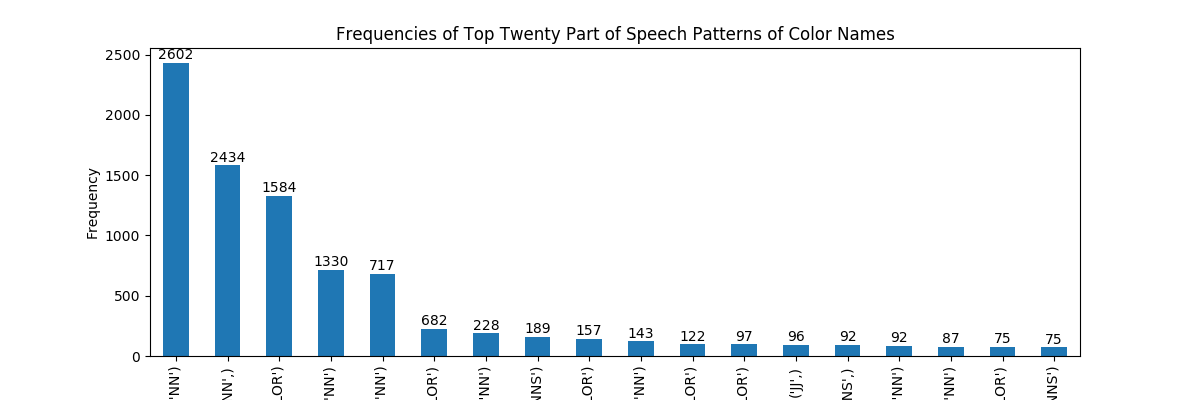

In [52]:
pos_series = pd.Series.from_array([count for (pattern, count) in patterns_sorted_by_value[0:19]])
plt.figure(figsize=(12, 4))
ax = pos_series[1:20].plot(kind='bar')
ax.set_title('Frequencies of Top Twenty Part of Speech Patterns of Color Names')
ax.set_xlabel('POS Pattern')
ax.set_ylabel('Frequency')
ax.set_xticklabels([str(pattern) for (pattern, count) in patterns_sorted_by_value[0:19]])
rects = ax.patches

# Make some labels.
labels = [count for (pattern, count) in patterns_sorted_by_value[0:19]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

## Scatter plot of basic color terms

In [60]:
#First need function mapping basic_color_categories to numbers
color_map = {
    'blue': 'xkcd:blue',
    'green': 'xkcd:green',
    'white': 'xkcd:white', 
    'gray': 'xkcd:grey',
    'pink': 'xkcd:pink',
    'brown': 'xkcd:brown',
    'red': 'xkcd:red',
    'gold': 'xkcd:gold',
    'rose': 'xkcd:rose',
    'tan': 'xkcd:tan',
    'cream': 'xkcd:cream',
    'yellow': 'xkcd:yellow',
    'peach': 'xkcd:peach',
    'beige': 'xkcd:beige',
    'orange': 'xkcd:orange',
    'violet': 'xkcd:violet',
    'black': 'xkcd:black',
    'silver': 'xkcd:silver',
    'sand': 'xkcd:sand',
    'coral': 'xkcd:coral',
    'purple': 'xkcd:purple',
    'teal': 'xkcd:teal',
    'clay': 'xkcd:clay',
    'plum': 'xkcd:plum',
    'lilac': 'xkcd:lilac',
    'taupe': 'xkcd:taupe',
    'grey': 'xkcd:grey',
    'UNKNOWN': 'xkcd:black'
}

In [66]:
color_names['basic_color_category'][0:5].map(color_map)

0     xkcd:sand
1    xkcd:black
2     xkcd:gold
3     xkcd:pink
4    xkcd:white
Name: basic_color_category, dtype: object

<IPython.core.display.Javascript object>


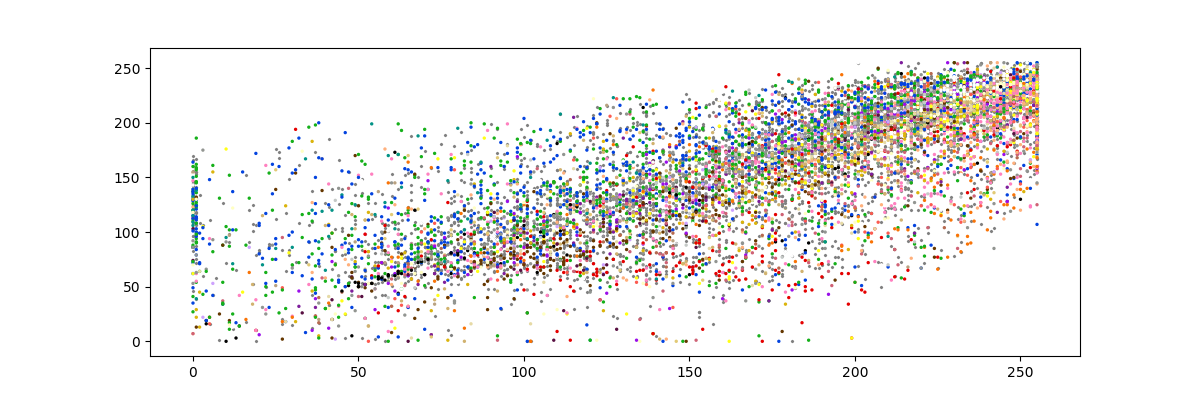

In [85]:
#Red * Green, 2-d
plt.figure(figsize=(12,4))
x_known = color_names['red'].loc[color_names['basic_color_category'] != 'UNKNOWN']
y_known = color_names['green'].loc[color_names['basic_color_category'] != 'UNKNOWN']
x_unknown = color_names['red'].loc[color_names['basic_color_category'] == 'UNKNOWN']
y_unknown = color_names['green'].loc[color_names['basic_color_category'] == 'UNKNOWN']
colors_known = color_names['basic_color_category'].loc[color_names['basic_color_category'] != 'UNKNOWN'].map(color_map)
plt.scatter(x_unknown,y_unknown, s=2, c='grey', marker='x')
plt.scatter(x_known, y_known, s=2, c=colors_known, marker='o')
plt.show()

<IPython.core.display.Javascript object>


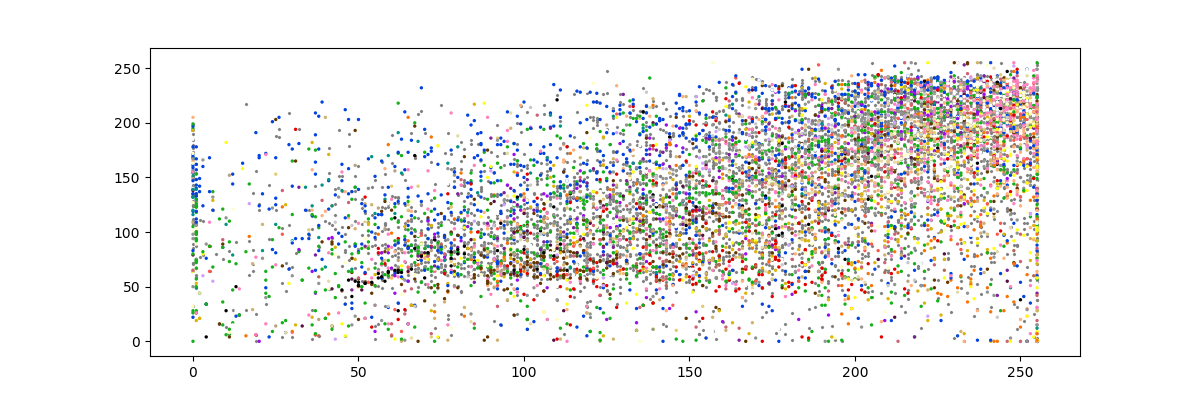

In [86]:
#Let's try red vs. blue
plt.figure(figsize=(12,4))
x_known = color_names['red'].loc[color_names['basic_color_category'] != 'UNKNOWN']
y_known = color_names['blue'].loc[color_names['basic_color_category'] != 'UNKNOWN']
x_unknown = color_names['red'].loc[color_names['basic_color_category'] == 'UNKNOWN']
y_unknown = color_names['blue'].loc[color_names['basic_color_category'] == 'UNKNOWN']
colors_known = color_names['basic_color_category'].loc[color_names['basic_color_category'] != 'UNKNOWN'].map(color_map)
plt.scatter(x_unknown,y_unknown, s=2, c='grey', marker='x')
plt.scatter(x_known, y_known, s=2, c=colors_known, marker='o')
plt.show()

## Now we should use gausian mixture modeling to find the outlines of the areas with the same basic color terms in 3-d rgb space

## Use kmeans clustering to find basic color terms automatically

In [33]:
#Slice the RGB columns
data = color_names[['red', 'green','blue']]

In [34]:
def cluster(myData, k):
    # Number of clusters
    kmeans = KMeans(n_clusters=k)
    # Fitting the input data
    kmeans = kmeans.fit(myData)
    # Getting the cluster labels
    labels = kmeans.predict(myData)
    # Centroid values
    centroids = kmeans.cluster_centers_
    distortion = sum(np.min(cdist(myData, kmeans.cluster_centers_, 'euclidean'), axis=1)) / myData.shape[0]
    return distortion 

### Find optimal number of clusters by plotting SSE ('Distortion')

In [35]:
distortions = []
for k in range(1,20):
    distortions.append(cluster(data, k))

print(distortions)
    
    

[96.898766471425517, 60.043102565838538, 50.026252652111552, 45.673085577529847, 41.728933097101077, 39.698524197196782, 37.481690632622296, 35.744622494413669, 34.136418257606266, 32.763324779417431, 31.610640015326066, 30.561900187575542, 29.738356858517541, 29.034507773908846, 28.211300116245532, 27.744307760135854, 27.068114276642483, 26.460683684962778, 25.976533161324319]


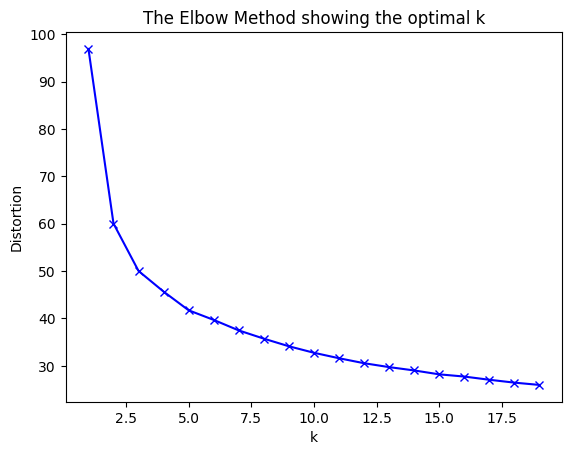

In [36]:
plt.plot(range(1,20), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

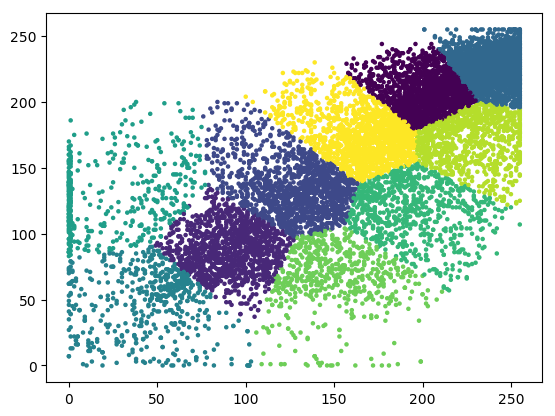

In [25]:
plt.scatter(data['red'], data['green'], c=labels, cmap='viridis', s=5)
plt.show()

In [1]:
from nltk import FreqDist

#Select pattern from choice list according to known distribution

In [5]:
choices = ['a', 'b', 'c']
probs = [.7, .2, .1]

from numpy.random import choice
from collections import defaultdict
counts = defaultdict(int)

for i in range(100):
    draw = choice(choices, 1, p=probs)[0]
    counts[draw] += 1

print(counts)


defaultdict(<class 'int'>, {'a': 65, 'b': 24, 'c': 11})
